In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from pycalib.models import CalibratedModel
from dirichletcal import FullDirichletCalibrator
from sklearn.model_selection import train_test_split

# Datasets

Here we generate 3 syntethic datasets that will be used to demonstrate some visualisation tools.

In [2]:
from sklearn.datasets import make_classification, make_blobs
dataset_binary = make_blobs(n_samples=10000, centers=5,
                            n_features=2,
                            random_state=42)

dataset_binary[1][:] = dataset_binary[1] > 2

## Another dataset to test
#dataset_binary = make_classification(n_samples=10000, n_classes=2,
#                                     n_features=2, n_redundant=0,
#                                     random_state=42)

Each dataset is just composed by the features $x$ and labels $y$. The following is a scatterplot of the binary dataset.

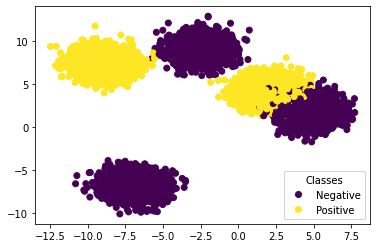

In [3]:
x, y = dataset_binary
fig, ax = plt.subplots()
scatter = ax.scatter(x[:, 0], x[:, 1], c=y)
handles, labels = scatter.legend_elements()
labels = ['Negative', 'Positive']
legend = ax.legend(handles, labels,
                    loc="lower right", title="Classes")
ax.add_artist(legend)

# Reliability diagram

We will first train a classifier, and a calibrator on top of it. We will then visualise the reliability diagram.

## Binary (only the positive class)

In [4]:
x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB()

Text(0.5, 1.0, 'Predicted probabilities')

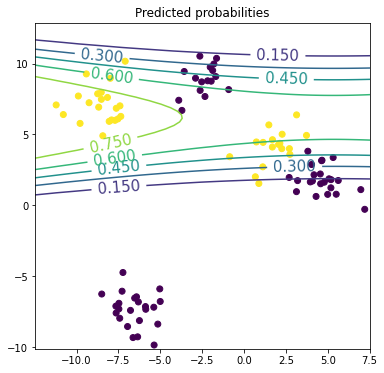

In [5]:
delta = 0.25
x0_grid = np.arange(x[:, 0].min(), x[:, 0].max(), delta)
x1_grid = np.arange(x[:, 1].min(), x[:, 1].max(), delta)
X0, X1 = np.meshgrid(x0_grid, x1_grid)
Y = clf.predict_proba(np.vstack((X0.flatten(), X1.flatten())).T)

fig, ax = plt.subplots(figsize=(6, 6))
CS = ax.contour(X0, X1, Y[:, 1].reshape(X0.shape))
ax.clabel(CS, inline=1, fontsize=15)
ax.scatter(x[:100, 0], x[:100, 1], c=y[:100])
ax.set_title('Predicted probabilities')

Text(0.5, 0, 'samples per bin')

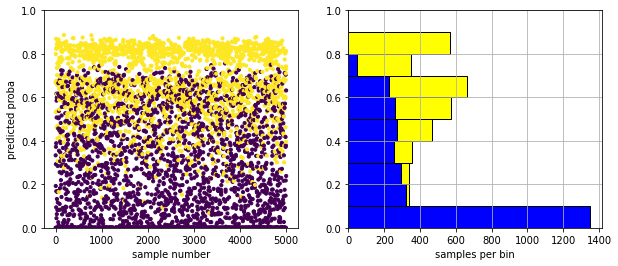

In [6]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)

p_clf = clf.predict_proba(x_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(range(len(p_clf[:,1])), p_clf[:,1], c=y_test, s=10)
ax1.set_ylim(0, 1)
ax1.set_xlabel('sample number')
ax1.set_ylabel('predicted proba')
ax2.hist([p_clf[y_test == 0, 1],
          p_clf[y_test == 1, 1]],
         bins=bins, orientation='horizontal', stacked=True,
         color=['blue', 'yellow'], edgecolor='black')
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_xlabel('samples per bin')

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Samples per bin')

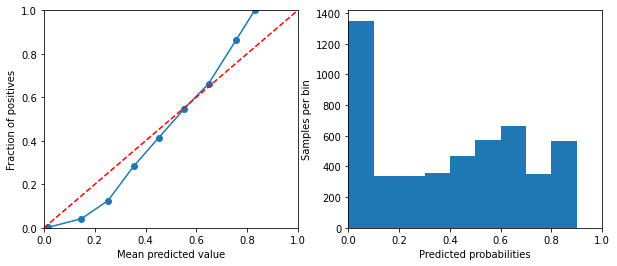

In [7]:
digitized = np.digitize(p_clf[:, 1], bins=bins)
pred_means = [p_clf[:, 1][digitized == i].mean() for i in range(1, n_bins+1)]
y_means = [y_test[digitized == i].mean() for i in range(1, n_bins+1)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(pred_means, y_means, 'o-')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlim(0, 1)
ax1.set_xlabel('Mean predicted value')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Fraction of positives')

ax2.hist(p_clf[:, 1], bins=bins)
ax2.set_xlim(0, 1)
ax2.set_xlabel('Predicted probabilities')
ax2.set_ylabel('Samples per bin')

Here we will use a Python class from the PyCalib library which stacks any calibrator on top of a given classifier. Then the calibrator can be trained with additional data.

In [8]:
cal = CalibratedModel(clf, FullDirichletCalibrator())
cal.fit(x_train, y_train)

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as 

CalibratedModel(base_estimator=GaussianNB(), method=FullDirichletCalibrator())

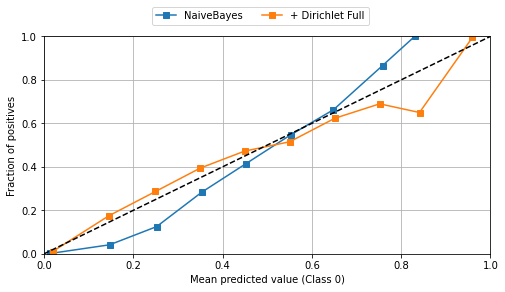

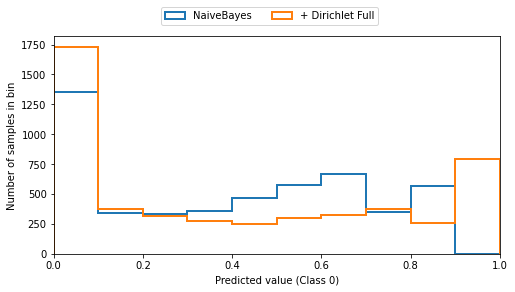

In [9]:
from pycalib.visualisations import plot_reliability_diagram

scores_list = [clf.predict_proba(x_test),
               cal.predict_proba(x_test)]

_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', '+ Dirichlet Full'), histogram=True)

## Multiclass

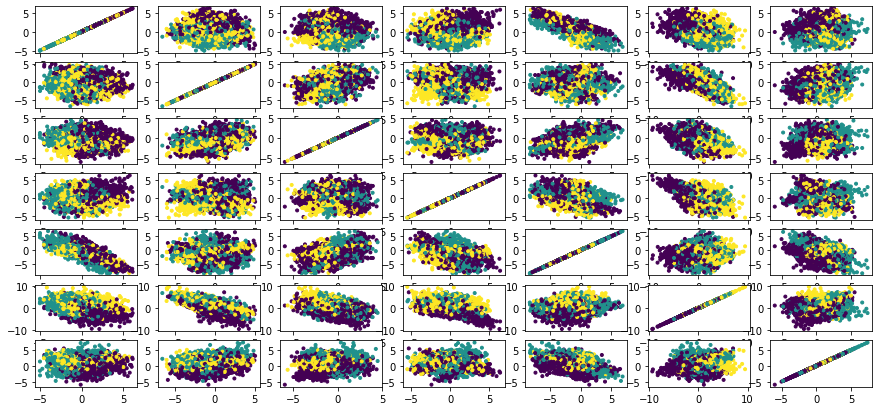

In [10]:
n_features = 7
dataset_ternary = make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=3,
                                    n_features=n_features,
                                    n_informative=5,
                                    random_state=42)

x, y = dataset_ternary

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(x[:,i], x[:,j], c=y, marker='.')

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


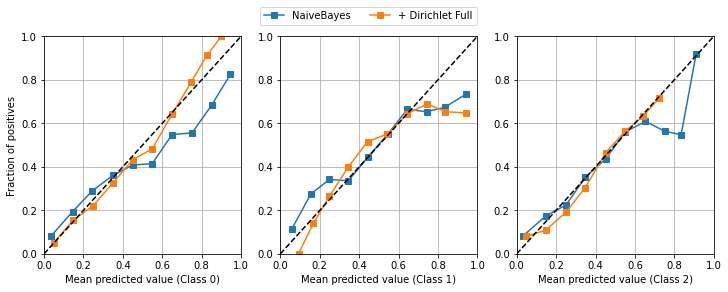

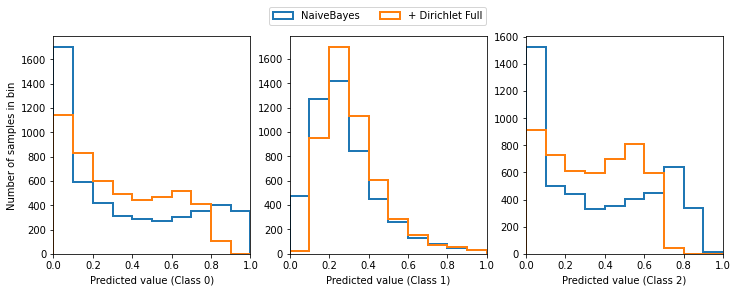

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)
cal = CalibratedModel(clf, FullDirichletCalibrator())
cal.fit(x_train, y_train)

scores_list = [clf.predict_proba(x_test),
          cal.predict_proba(x_test)]

_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', '+ Dirichlet Full'),
                             histogram=True)

# Reliability Diagram gaps

## Binary

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


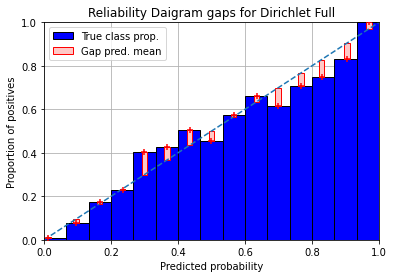

In [12]:
from pycalib.visualisations import plot_binary_reliability_diagram_gaps

x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

est_scores = cal.predict_proba(x_test)
fig, ax = plot_binary_reliability_diagram_gaps(y_test, est_scores, n_bins=15)
_ = ax.set_title('Reliability Daigram gaps for Dirichlet Full')

## Multiclass

We can plot only the most confident probability per sample.

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


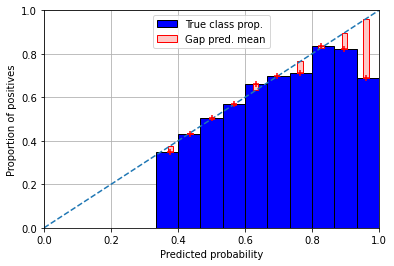

In [13]:
from pycalib.visualisations import plot_multiclass_reliability_diagram_gaps

from sklearn.preprocessing import OneHotEncoder

x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

probas = cal.predict_proba(x_test)
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=False)

We can compute the confidence-ECE in a similar way we did the figure:

$$
    \mathsf{confidence{-}ECE}  = \sum_{i=1}^M \frac{|B_{i}|}{N} |\bar{y}(B_{i}) - \bar{p}(B_{i})|
$$

In [14]:
from pycalib.metrics import conf_ECE

print('conf-ECE = ', conf_ECE(probas, y_test))

conf-ECE =  0.013420458118141413


or the maximum error confidence-MCE:

$$
\mathsf{confidence{-}MCE} = \max_{i \in \{1, \ldots, M\}} |\bar{y}(B_i) - \bar{p}(B_i)|
$$

In [15]:
from pycalib.metrics import conf_MCE

print('conf-MCE = ', conf_MCE(probas, y_test))

conf-MCE =  0.2734759959078181


Or all predicted probabilities per class

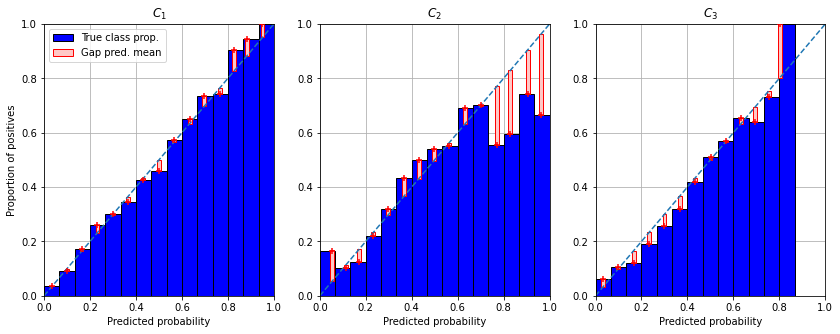

In [16]:
fig = plt.figure(figsize=(14, 5))
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=True, fig=fig)

$$
\mathsf{classwise{-}ECE}  = \frac{1}{K}\sum_{j=1}^K \sum_{i=1}^M \frac{|B_{i,j}|}{N} |\bar{y}_j(B_{i,j}) - \bar{p}_j(B_{i,j})|,
$$

In [17]:
from pycalib.metrics import classwise_ECE

classwise_ECE(probas, y_test)

# TODO: to be added
# from pycalib.metrics import classwise_MCE

0.07744047243267477

# Calibration maps

Calibration maps show the transformation that the calibrator performs to the classifier's scores. This is a map function from $C$ to $C$ where $C$ is the number of classes. In the binary case it is comonly shown for the positive class

## Binary calibration maps

In the binary case the calibration map corresponds to a 1 to 1 function that can be visualised in a 2d lineplot.

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


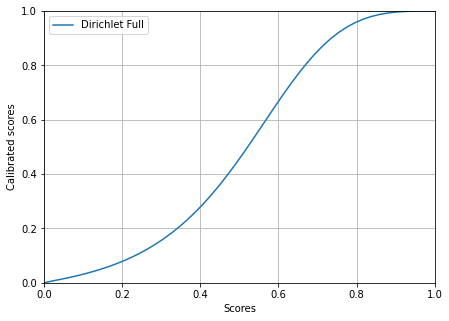

In [18]:
import matplotlib.pyplot as plt

x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

scores_linspace = np.linspace(0, 1, 50)
scores_linspace = np.vstack((1-scores_linspace, scores_linspace)).T
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
calibrated = cal.calibrator.predict_proba(scores_linspace)
ax.plot(scores_linspace[:, 1], calibrated[:, 1], label='Dirichlet Full')
ax.legend()
ax.set_xlabel('Scores')
ax.set_ylabel('Calibrated scores')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()

## 2D slices of Ternary Calibration maps

With 3 classes the calibration map corresponds to a function from 3 to 3 dimensions. As this is difficult to visualise we propose several approaches that show part of the map.

One is to show 3 calibration maps from 3 to 1 dimension. Each calibration map shows only the output score for one of the classes. Because the 3 input dimensions live in a 2D simplex, it is possible to visualise in a 2D plane, while the output scores are shown as a heatmap.

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


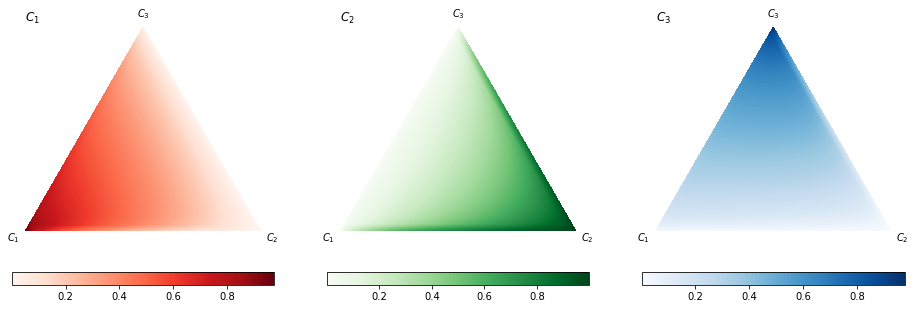

In [19]:
x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

from pycalib.visualisations.ternary import draw_func_contours, plot_converging_lines_pvalues, get_converging_lines

c_mark = [{'color':[.5, 0, 0], 'marker':'.', 'label':r'$C_1$', 'cmap':'Reds'},
          {'color':[0, .5, 0], 'marker':'x', 'label':r'$C_2$', 'cmap':'Greens'},
          {'color':[0, 0, .5], 'marker':'+', 'label':r'$C_3$', 'cmap':'Blues'}]

fig = plt.figure(figsize=(16, 5))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=c_mark[i]['cmap'])

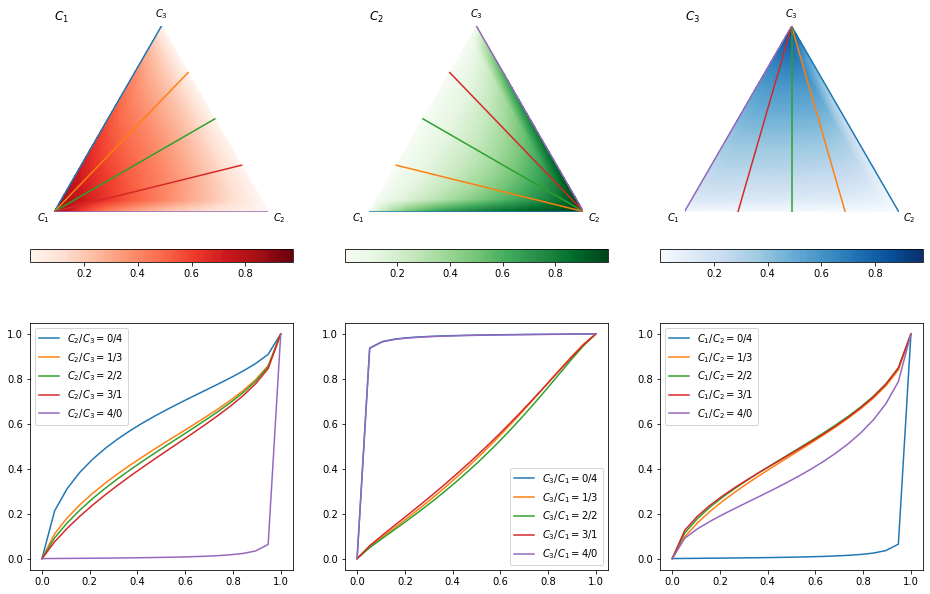

In [20]:
  fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)

    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=c_mark[i]['cmap'],
                       nlevels=100, subdiv=4, draw_lines=5, class_index=i)

    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=20, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

Another way to visualise the full mapping from 3 scores to 3 calibrated scores is to consider that both input and output scores live in a 2D simplex, which means that we can visualise the calibration map as arrows that start and end in a 2D position in the simplex. In this drawing we decided to color the arrows by the predicted class color after calibration.

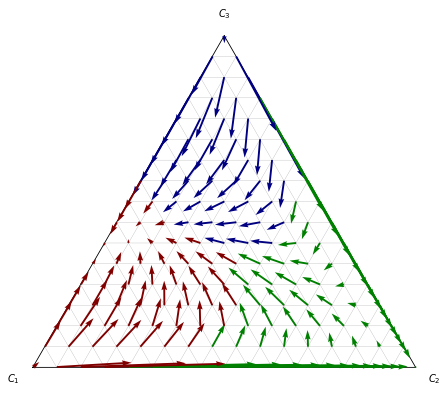

In [21]:
from pycalib.visualisations.barycentric import draw_calibration_map
from pycalib.visualisations.barycentric import get_mesh_bc
from pycalib.models import CalibratedModel

from dirichletcal import FullDirichletCalibrator, FixedDiagonalDirichletCalibrator, DirichletCalibrator

P_bc_grid = get_mesh_bc(subdiv=4)

calibrated = cal.calibrator.predict_proba(P_bc_grid)
color = [c_mark[i]['color'] for i in calibrated.argmax(axis=1).astype(int)]
fig = plt.figure(figsize=(7, 7))
_ = draw_calibration_map(P_bc_grid, calibrated, color=color,  subdiv=4, fig=fig)

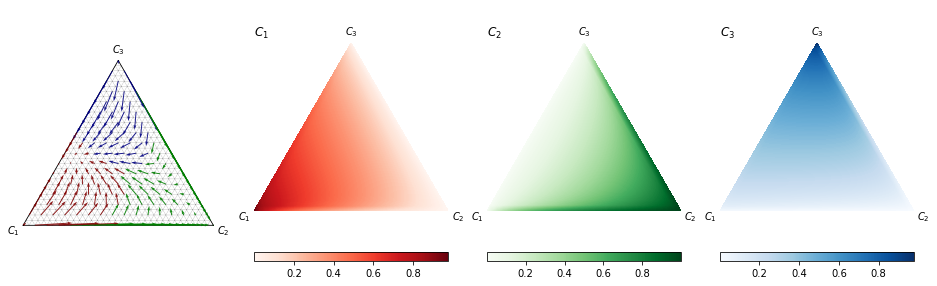

In [22]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 4, 1)
fig = draw_calibration_map(P_bc_grid, calibrated, color=color, subdiv=5, fig=fig, ax=ax, alpha=0.9)

for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(1, 4, i+2)
    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=c_mark[i]['cmap'])